# Quiz 1: Multimodal Emotion Analysis with Attention Mechanism
Task Description
Developed a predictive model that uses multimodal features (visual and textual) to classify emotions. To do this, using the CMU-MultimodalSDK dataset. The dataset can be obtained from instruction in https://github.com/CMU-MultiComp-Lab/CMU-MultimodalSDK?tab=readme-ov-file. 

In [1]:
!git clone https://github.com/CMU-MultiComp-Lab/CMU-MultimodalSDK.git

Cloning into 'CMU-MultimodalSDK'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 100 (delta 13), reused 95 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (100/100), 294.05 KiB | 4.03 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
%cd CMU-MultimodalSDK
!pip install -e .

/kaggle/working/CMU-MultimodalSDK
Obtaining file:///kaggle/working/CMU-MultimodalSDK
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.7 MB/s eta 0:00:00
  Running setup.py develop for mmsdk


In [11]:
import os
import sys
sys.path.append('/kaggle/working/CMU-MultimodalSDK/mmsdk')
from mmsdk import mmdatasdk
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from mmsdk import mmdatasdk
import numpy as np
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
# from data_loader import load_cmu_mosi_data
# from models import CrossModalAttentionFusion, GatedCrossModalAttentionFusion
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
deployed_path = '/kaggle/input/deployed/MOSI'

## Fetching and preparing the data

In [7]:
# A simple averaging function to align high-frequency features to word intervals
def myavg(intervals, features):
    return np.average(features, axis=0)

# The collate function from your original mosi_dataset.py
def multi_collate(batch):

    word2id = defaultdict(lambda: len(word2id))
    PAD = word2id['<pad>']
    # for later use we sort the batch in descending order of length
    batch = sorted(batch, key=lambda x: x[0][0].shape[0], reverse=True)
    
    # get the data out of the batch - use pad sequence util functions from PyTorch to pad things
    labels = torch.cat([torch.from_numpy(sample[1]) for sample in batch], dim=0)
    sentences = pad_sequence([torch.FloatTensor(sample[0][0]) for sample in batch], batch_first=True, padding_value=PAD)
    visual = pad_sequence([torch.FloatTensor(sample[0][1]) for sample in batch], batch_first=True)
    acoustic = pad_sequence([torch.FloatTensor(sample[0][2]) for sample in batch], batch_first=True)

    # lengths are useful later in using RNNs
    lengths = torch.FloatTensor([sample[0][0].shape[0] for sample in batch])
    
    return sentences, visual, acoustic, labels, lengths


def load_cmu_mosi_data(deployed_path=deployed_path):
    """
    Downloads, processes, and loads the CMU-MOSI dataset into PyTorch DataLoaders.
    
    Args:
        deployed_path (str): The directory where the processed data will be saved.
    
    Returns:
        tuple: A tuple containing the train, valid, and test DataLoaders.
    """
    
    if not os.path.exists(deployed_path):
        print("Processed data not found. Starting data processing...")

        try:
            # for mod in modalities:
            cmumosi_highlevel = mmdatasdk.mmdataset(mmdatasdk.cmu_mosi.highlevel, 'cmumosi/')
        except RuntimeError:
            print("CMU-MOSI data already downloaded. Loading from disk.")
            cmumosi_highlevel = mmdatasdk.mmdataset('cmumosi/')

        #Aligning to the words to get word-level alignments
        cmumosi_highlevel.align('glove_vectors',collapse_functions=[myavg])
        cmumosi_highlevel.impute('glove_vectors')

        #Aligning to the computational labels, thus removing the unsupervised components of CMU-MOSI
        
        cmumosi_highlevel.add_computational_sequences(mmdatasdk.cmu_mosi.labels,'cmumosi/')
        # # Add labels
        cmumosi_highlevel.align('Opinion Segment Labels')
        cmumosi_highlevel.hard_unify()
        
        # Deploying the files to the disk and reading them again 

        deploy_files = {x: x for x in cmumosi_highlevel.computational_sequences.keys()}
        cmumosi_highlevel.deploy(deployed_path, deploy_files)
        print(f"Data processed and saved to {deployed_path}")
    else:
        print("Found processed data. Loading from deployed folder.")

    # Loading the deployed (aligned) data
    aligned_cmumosi_highlevel=mmdatasdk.mmdataset(deployed_path)

    # Getting the standard folds as defined by the CMU-MOSI dataset
    train_fold = mmdatasdk.cmu_mosi.standard_folds.standard_train_fold
    valid_fold = mmdatasdk.cmu_mosi.standard_folds.standard_valid_fold
    test_fold = mmdatasdk.cmu_mosi.standard_folds.standard_test_fold

    # Get the tensors for each fold
    # The `non_sequences` argument ensures that labels are not treated as a sequence.
    # The `direction=False` argument means we don't handle directional data.
    # The `seq_len` argument sets the maximum sequence length. It's a good practice
    # to find the max length in the dataset, set to 25.

    train_tensors=aligned_cmumosi_highlevel.get_tensors(
        seq_len=25, non_sequences=["Opinion Segment Labels"],
        direction=False, folds=[train_fold]
    )
    valid_tensors=aligned_cmumosi_highlevel.get_tensors(
        seq_len=25, non_sequences=["Opinion Segment Labels"],
        direction=False, folds=[valid_fold]
    )
    test_tensors=aligned_cmumosi_highlevel.get_tensors(
        seq_len=25, non_sequences=["Opinion Segment Labels"],
        direction=False, folds=[test_fold]
    )
    
    # Custom Dataset class to handle the mmsdk tensors
    class CMUMOSITensorDataset(Dataset):
        def __init__(self, tensors):
            # The keys will be the computational sequence names
            self.keys = list(tensors[0].keys())
            
            # Extracting features and labels
            # The .get_tensors() function returns the data in a specific order:
            # First dimension is sample index, second is sequence length.
            self.text_features = tensors[0]['glove_vectors']
            self.visual_features = tensors[0]['FACET_4.1']
            self.acoustic_features = tensors[0]['COVAREP']
            self.labels = tensors[0]['Opinion Segment Labels']

        def __len__(self):
            return self.text_features.shape[0]

        def __getitem__(self, idx):
            # Returns text, visual, and acoustic features, and the label
            text = self.text_features[idx]
            visual = self.visual_features[idx]
            acoustic = self.acoustic_features[idx]
            label = self.labels[idx]
            # print("idx:",idx, text.shape)
            # print("idx:",idx, label.shape)
            return (text, visual, acoustic), label

    train_dataset = CMUMOSITensorDataset(train_tensors)
    valid_dataset = CMUMOSITensorDataset(valid_tensors)
    test_dataset = CMUMOSITensorDataset(test_tensors)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=multi_collate)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=multi_collate)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=multi_collate)

    return train_loader, valid_loader, test_loader


## Model Design Philosophy:

The core challenge in multimodal sentiment analysis is not just to combine data, but to do so in a way that allows each modality (text, visual) to enhance and contextualize the others. Simply concatenating features often leads to models that are either biased towards the most dominant modality or fail to capture the subtle interactions between them. To overcome this, our model is built on a philosophy of guided and dynamic fusion, where attention mechanisms are integral.

My design process follows a three-step hierarchy:

1. **Unimodal Feature Extraction**: First, each modality is processed independently by a dedicated `Bi-directional LSTM`. The LSTMs are crucial as they capture temporal dependencies within each sequence. 

2. **Guided Fusion**: This is the heart of our design. Instead of a simple concatenation, I use a gated fusion approach where the visual features are used to modulate the textual features. This is inspired by the human brain, where non-verbal cues (like facial expressions) directly influence how we interpret spoken words.

3. **Cross-Modal Self-Attention**: Once the features are fused, I apply a self-attention mechanism. This layer dynamically weighs the importance of different parts of the newly fused sequence. This is a critical step because it allows the model to learn which parts of the fused representation are most important for predicting sentiment, without being confined by the original sequence order.

This hierarchical design ensures our model learns deep, modality-specific representations before intelligently combining them, leading to more nuanced and accurate predictions.

**Fusion Approach: Gated Feature Modulation**
The fusion strategy in our model is centered around the `ModalityGatedFusion` class, which implements a gated fusion mechanism. This approach is superior to simpler methods for several reasons:

* **How it Works**: The `ModalityGatedFusion` takes the processed visual and text features as input. It first passes the visual features through a linear layer and a sigmoid activation function to create a gate. This gate is a set of values between 0 and 1. This gate is then element-wise multiplied with the textual features.

* **Why It’s Effective**: This multiplicative interaction is a powerful form of dynamic weighting. The model learns to generate a gate that can amplify (values close to 1) or suppress (values close to 0) specific textual features based on the context provided by the visual data. For example, if the text says "amazing" but the visual cues show a negative expression (e.g., a frown), the visual gate can learn to suppress the influence of the word "amazing," leading to a more accurate final prediction. This allows for fine-grained interaction and solves the challenge of conflicting information between modalities.

In [8]:
class ModalityGatedFusion(nn.Module):
    def __init__(self, text_dim, visual_dim):
        super(ModalityGatedFusion, self).__init__()
        
        # A simple linear layer to project the visual feature to the text dimension
        self.visual_to_text = nn.Linear(visual_dim, text_dim)
        
    def forward(self, text_features, visual_features):
        # We need to ensure the sequence lengths are the same.
        # This is handled by the data loader, but we'll re-check.
        assert text_features.shape[1] == visual_features.shape[1], "Sequence lengths must match for fusion"
        
        # Project the visual features to the same dimension as the text features
        visual_projected = self.visual_to_text(visual_features)
        
        # Apply a sigmoid gate to the projected visual features
        gate = torch.sigmoid(visual_projected)
        
        # Element-wise multiplication to "gate" the text features
        # This means the visual data learns to amplify or suppress parts of the text features
        fused_features = text_features * gate
        
        return fused_features


class GatedCrossModalAttentionFusion(nn.Module):
    def __init__(self, text_input_dim, visual_input_dim, text_lstm_dim, visual_lstm_dim, output_dim=1, num_layers=2, dropout=0.3):
        super(GatedCrossModalAttentionFusion, self).__init__()
        
        # --- Unimodal Feature Extraction ---
        # Text LSTM with batch normalization and dropout
        
        self.text_lstm = nn.LSTM(input_size=text_input_dim, 
            hidden_size=text_lstm_dim, num_layers = num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.text_bn = nn.BatchNorm1d(text_lstm_dim * 2)
        self.text_dropout = nn.Dropout(p=dropout)

        # Visual LSTM with batch normalization and dropout
        self.visual_lstm = nn.LSTM(input_size=visual_input_dim, 
            hidden_size=visual_lstm_dim, num_layers = num_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.visual_bn = nn.BatchNorm1d(visual_lstm_dim * 2)
        self.visual_dropout = nn.Dropout(p=dropout)
        
        # --- Modality Gating Fusion ---
        self.modality_gate = ModalityGatedFusion(text_dim=text_lstm_dim * 2, visual_dim=visual_lstm_dim * 2)

        # --- Self-Attention on Fused Features ---
        self.self_attention = nn.MultiheadAttention(embed_dim=text_lstm_dim * 2, num_heads=8, dropout=dropout, batch_first=True)
        
        # --- Final Classification Layers ---
        self.fc1 = nn.Linear(text_lstm_dim * 2, text_lstm_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(text_lstm_dim, output_dim)
        self.final_dropout = nn.Dropout(p=dropout)


    def forward(self, text_x, text_lengths, visual_x):
        # 1. Unimodal Feature Extraction
        # Text
        packed_text = nn.utils.rnn.pack_padded_sequence(text_x, text_lengths, batch_first=True, enforce_sorted=False)
        text_output, _ = self.text_lstm(packed_text)
        text_output, _ = nn.utils.rnn.pad_packed_sequence(text_output, batch_first=True)
        # Transpose for BatchNorm1d: (batch_size, channels, sequence_length)
        text_output = self.text_bn(text_output.permute(0, 2, 1)).permute(0, 2, 1)
        text_output = self.text_dropout(text_output)
        
        # Visual
        visual_output, _ = self.visual_lstm(visual_x)
        visual_output = self.visual_bn(visual_output.permute(0, 2, 1)).permute(0, 2, 1)
        visual_output = self.visual_dropout(visual_output)

        # 2. Modality Gating Fusion
        # Fuses visual features into the text stream
        fused_features = self.modality_gate(text_output, visual_output)
        
        # 3. Self-Attention on Fused Features
        # The attention mask ensures we don't attend to padding tokens
        attention_mask = (text_x.sum(dim=-1) == 0)
        fused_attention_output, attention_weights = self.self_attention(
            query=fused_features,
            key=fused_features,
            value=fused_features,
            key_padding_mask=attention_mask
        )

        # 4. Final Aggregation and Classification
        # We'll use a mean pooling to get a single vector from the sequence
        final_vector = torch.sum(fused_attention_output, dim=1)
        
        # Pass through linear layers for classification
        output = self.fc1(final_vector)
        output = self.relu(output)
        output = self.final_dropout(output)
        output = self.fc2(output)
        
        return output, attention_weights

### Loading the pre fetched data

In [9]:
train_loader, valid_loader, test_loader = load_cmu_mosi_data()

print("\nTraining and validation loaders created successfully.")
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in valid_loader: {len(valid_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

# Inspect a single batch
for sentences, visual, acoustics, labels, lengths in train_loader:
    print("\nExample batch shapes:")
    print(f"Sentences: {sentences.shape}")
    print(f"Visual: {visual.shape}")
    print(f"Acoustic: {acoustics.shape}")
    # Note: the collate function in your original `mosi_dataset.py` included acoustic data.
    # This updated version of `multi_collate` is simpler and only handles text and visual as per the quiz requirement.
    # You will need to add acoustic data back into the collate function and models if you want to use it.
    print(f"Labels: {labels.shape}")
    print(f"Lengths: {lengths.shape}")
    break

Found processed data. Loading from deployed folder.
[2025-09-03 20:09:50.024] | Success | Computational sequence read from file /kaggle/input/deployed/MOSI/Opinion Segment Labels.csd ...
[2025-09-03 20:09:51.188] | Status  | Checking the integrity of the <Opinion Segment Labels> computational sequence ...
[2025-09-03 20:09:51.188] | Status  | Checking the format of the data in <Opinion Segment Labels> computational sequence ...


[2025-09-03 20:09:51.996] | Success | <Opinion Segment Labels> computational sequence data in correct format.
[2025-09-03 20:09:51.996] | Status  | Checking the format of the metadata in <Opinion Segment Labels> computational sequence ...
[2025-09-03 20:09:51.996] | Success | <Opinion Segment Labels> computational sequence metadata in correct format.
[2025-09-03 20:09:51.996] | Success | <Opinion Segment Labels> computational sequence is valid!
[2025-09-03 20:09:52.000] | Success | Computational sequence read from file /kaggle/input/deployed/MOSI/glove_vectors.csd ...
[2025-09-03 20:09:56.054] | Status  | Checking the integrity of the <glove_vectors> computational sequence ...
[2025-09-03 20:09:56.055] | Status  | Checking the format of the data in <glove_vectors> computational sequence ...


[2025-09-03 20:10:00.091] | Success | <glove_vectors> computational sequence data in correct format.
[2025-09-03 20:10:00.091] | Status  | Checking the format of the metadata in <glove_vectors> computational sequence ...
[2025-09-03 20:10:00.091] | Success | <glove_vectors> computational sequence metadata in correct format.
[2025-09-03 20:10:00.091] | Success | <glove_vectors> computational sequence is valid!
[2025-09-03 20:10:00.096] | Success | Computational sequence read from file /kaggle/input/deployed/MOSI/COVAREP.csd ...
[2025-09-03 20:10:03.448] | Status  | Checking the integrity of the <COVAREP> computational sequence ...
[2025-09-03 20:10:03.448] | Status  | Checking the format of the data in <COVAREP> computational sequence ...


[2025-09-03 20:10:05.364] | Success | <COVAREP> computational sequence data in correct format.
[2025-09-03 20:10:05.364] | Status  | Checking the format of the metadata in <COVAREP> computational sequence ...
[2025-09-03 20:10:05.364] | Success | <COVAREP> computational sequence metadata in correct format.
[2025-09-03 20:10:05.364] | Success | <COVAREP> computational sequence is valid!
[2025-09-03 20:10:05.376] | Success | Computational sequence read from file /kaggle/input/deployed/MOSI/FACET_4.1.csd ...
[2025-09-03 20:10:08.704] | Status  | Checking the integrity of the <FACET_4.1> computational sequence ...
[2025-09-03 20:10:08.704] | Status  | Checking the format of the data in <FACET_4.1> computational sequence ...


[2025-09-03 20:10:10.123] | Success | <FACET_4.1> computational sequence data in correct format.
[2025-09-03 20:10:10.123] | Status  | Checking the format of the metadata in <FACET_4.1> computational sequence ...
[2025-09-03 20:10:10.123] | Success | <FACET_4.1> computational sequence metadata in correct format.
[2025-09-03 20:10:10.123] | Success | <FACET_4.1> computational sequence is valid!
[2025-09-03 20:10:10.123] | Success | Dataset initialized successfully ... 
[2025-09-03 20:10:10.123] | Status  | Hard unify was called ...
[2025-09-03 20:10:10.126] | Success | Hard unify completed ...
[2025-09-03 20:10:12.816] | Warning | Key WKA5OygbEKI[0] doesn't belong to any fold ... 
[2025-09-03 20:10:12.816] | Warning | Key WKA5OygbEKI[10] doesn't belong to any fold ... 
[2025-09-03 20:10:12.816] | Warning | Key WKA5OygbEKI[11] doesn't belong to any fold ... 
[2025-09-03 20:10:12.816] | Warning | Key WKA5OygbEKI[12] doesn't belong to any fold ... 
[2025-09-03 20:10:12.816] | Warning | Key

## Training and Evaluation functions

This section provides the key functions , explaining their purpose and what they achieve in the the project.

1. **def cor(X, Y)**

This function calculates the Pearson correlation coefficient between two arrays, X and Y.

2. **def visualize_attention(attention_weights, title, xticklabels=None, yticklabels=None)**

This function generates an attention heatmap using the seaborn library. It visualizes the attention_weights tensor, which represents the importance scores the model assigns when processing a sequence. 

3. **def train_and_evaluate(model, model_name, train_loader, valid_loader, test_loader, num_epochs=10)** 

This is the main function that manages the entire model training and evaluation pipeline.

4. **Hyperparameters**
* a loss function (nn.MSELoss for regression),
* optimizer (Adam).
* TEXT_LSTM_DIM = 128
* VISUAL_LSTM_DIM = 64
* OUTPUT_DIM = 1
* TEXT_INPUT_DIM = 300
* VISUAL_INPUT_DIM = 47
* num_epochs = 50

In [ ]:
def cor(X, Y):
    return np.mean(((X - np.mean(X)) * (Y - np.mean(Y)))) / (np.var(X) ** 0.5) / (np.var(Y) ** 0.5)

def visualize_attention(attention_weights, title, xticklabels=None, yticklabels=None):
    plt.figure(figsize=(12, 10))
    sns.heatmap(attention_weights.cpu().detach().numpy(), cmap='YlGnBu', xticklabels=xticklabels, yticklabels=yticklabels)
    plt.title(title)
    plt.xlabel('Keys (Source Modality)')
    plt.ylabel('Queries (Target Modality)')
    plt.show()

def train_and_evaluate(model, model_name, train_loader, valid_loader, test_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.MSELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    print(f"----- Training and Evaluating {model_name} -----")
    print(f"Training on device: {device}")
    
    best_valid_f1 = 0
    best_model_state = None
    running_loss = 0.0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        tot_num = 0
        tot_err = 0
        tot_right = 0
        label_all = []
        output_all = []
        for i, data in enumerate(train_loader):
            sentences, visual, acoustic, labels, lengths = data
            sentences = sentences.to(device)
            visual = visual.to(device)
            labels = labels.to(torch.float).to(device)
            # print(labels.dtype)
            lengths = lengths.cpu()

            # 2. Correct the lengths tensor to prevent out-of-bounds indexing
            max_seq_len = sentences.size(1)
            lengths = lengths.clamp(max=max_seq_len)
            optimizer.zero_grad()
            
            outputs, _ = model(sentences, lengths, visual)
            
            err = torch.sum(torch.abs(outputs - labels))
            tot_right += torch.sum(torch.eq(torch.sign(labels), torch.sign(outputs)))
            tot_err += err
            tot_num += visual.size()[0]
            
            loss = criterion(outputs.view(-1), labels.view(-1))
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 50 == 49:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0

        train_mae = tot_err / tot_num
        train_acc = float(tot_right) / tot_num
        avg_train_loss = total_loss / len(train_loader)
        
        model.eval()
        valid_loss = 0
        all_preds = []
        all_labels = []
        tot_num = 0
        tot_err = 0
        tot_right = 0
        label_all = []
        output_all = []
        with torch.no_grad():
            for data in valid_loader:
                sentences, visual, acoustic, labels, lengths = data
                sentences = sentences.to(device)
                visual = visual.to(device)
                labels = labels.to(torch.float).to(device)
                lengths = lengths.cpu()

                # 2. Correct the lengths tensor to prevent out-of-bounds indexing
                max_seq_len = sentences.size(1)
                lengths = lengths.clamp(max=max_seq_len)

                outputs, _ = model(sentences, lengths, visual)

                output_all.extend(outputs.data.cpu().tolist())
                label_all.extend(labels.data.cpu().tolist())

                err = torch.sum(torch.abs(outputs - labels))
                tot_err += err
                labels = torch.ge(labels, 0)
                pred = torch.ge(outputs, 0)
                tot_right += torch.sum(torch.eq(labels, pred)).data.cpu().tolist()
                tot_num += visual.size()[0]
                
                loss = criterion(outputs.view(-1), labels.view(-1))
                valid_loss += loss.item()
                
                # preds = (torch.sigmoid(outputs) > 0.5).int().cpu().squeeze()
                # all_preds.extend(preds.tolist())
                # all_labels.extend(labels.int().tolist())
        if tot_num != 0:
            valid_mae = tot_err / tot_num
            valid_cor = cor(output_all, label_all)
            valid_acc = float(tot_right) / tot_num
            avg_valid_loss = valid_loss / len(valid_loader)
            # Convert lists to NumPy arrays and cast to integers for F1-score
            # This correctly handles the "list to int" problem
            all_labels_int = (np.array(label_all) > 0).astype(int)
            all_preds_int = (np.array(output_all) > 0).astype(int)
            
            f1 = f1_score(all_labels_int, all_preds_int, average="weighted")
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Train MAE: {train_mae:.4f}")
        print(f" Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_acc:.4f}, Valid Corr: {valid_cor:.4f}, Valid MAE: {valid_mae:.4f}, Valid F1: {f1:.4f}")
        
        if f1 > best_valid_f1:
            best_valid_f1 = f1
            best_model_state = model.state_dict()
    
    print("\nTraining complete. Evaluating on test set...")
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    model.eval()
    all_preds = []
    all_labels = []
    tot_num = 0
    tot_err = 0
    tot_right = 0
    label_all = []
    output_all = []
    with torch.no_grad():
        for data in test_loader:
            sentences, visual, acoustic, labels, lengths = data
            sentences = sentences.to(device)
            visual = visual.to(device)
            labels =  labels.to(torch.float).to(device)
            lengths = lengths.cpu()

            # 2. Correct the lengths tensor to prevent out-of-bounds indexing
            max_seq_len = sentences.size(1)
            lengths = lengths.clamp(max=max_seq_len)
            
            outputs, attention = model(sentences, lengths, visual)
            output_all.extend(outputs.tolist())
            label_all.extend(labels.tolist())

            err = torch.sum(torch.abs(outputs - labels))
            tot_err += err
            tot_num += visual.size()[0]
            labels = torch.ge(labels, 0)
            pred = torch.ge(outputs, 0)
            tot_right += torch.sum(torch.eq(labels, pred))
            # preds = (torch.sigmoid(outputs) > 0.5).int().cpu().squeeze()
            # all_preds.extend(preds.tolist())
            # all_labels.extend(labels.int().tolist())
            
    test_mae = tot_err / tot_num
    test_cor = cor(output_all, label_all)
    test_acc = float(tot_right) / tot_num
    # Convert lists to NumPy arrays and cast to integers for F1-score
    # This correctly handles the "list to int" problem
    all_labels_int = (np.array(label_all) > 0).astype(int)
    all_preds_int = (np.array(output_all) > 0).astype(int)
    
    test_f1 = f1_score(all_labels_int, all_preds_int, average="weighted")
    
    print(f"\nFinal Test Accuracy: {test_acc:.4f}, Test MAE: {test_mae:.4f}, Test Corr : {test_cor:.4f}, Test F1-score: {test_f1:.4f}")
    
    print("\nGenerating attention heatmaps for a sample from the test set...")
    sample_index = 0
    with torch.no_grad():
        sentences, visual, acoustic, labels, lengths = next(iter(test_loader))
        
        sentences = sentences.to(device)
        visual = visual.to(device)
        lengths = lengths.cpu()

        _, attention_weights = model(sentences, lengths, visual)

        sample_length = lengths[sample_index].int().cpu()

        sample_attention = attention_weights[sample_index].squeeze()[:sample_length, :sample_length]

        text_labels = [f'Word {i}' for i in range(sample_attention.shape[0])]
        visual_labels = [f'Visual {i}' for i in range(sample_attention.shape[1])]
        
        # The new model only returns one attention matrix, so we'll visualize that.
        visualize_attention(sample_attention, f"Self-Attention on Fused Features ({model_name})", xticklabels=text_labels, yticklabels=visual_labels)
        
    
    return {'accuracy': test_acc, 'Test MAE': test_mae, 'Test Corr' : test_cor, 'f1': test_f1}

--- Starting Multimodal Model Comparison ---
----- Training and Evaluating Gated Cross-Modal Attention -----
Training on device: cuda
Epoch 1/50, Train Loss: 2.7378, Train Acc: 0.5518, Train MAE: 1.3509
 Valid Loss: 0.4469, Valid Acc: 0.7290, Valid Corr: 0.5520, Valid MAE: 1.3110, Valid F1: 0.7101
Epoch 2/50, Train Loss: 1.8170, Train Acc: 0.6571, Train MAE: 1.1162
 Valid Loss: 0.4691, Valid Acc: 0.7103, Valid Corr: 0.6005, Valid MAE: 1.0642, Valid F1: 0.6919
Epoch 3/50, Train Loss: 1.6348, Train Acc: 0.6999, Train MAE: 1.0488
 Valid Loss: 0.6219, Valid Acc: 0.7336, Valid Corr: 0.6034, Valid MAE: 1.0512, Valid F1: 0.7224
Epoch 4/50, Train Loss: 1.3584, Train Acc: 0.7272, Train MAE: 0.9639
 Valid Loss: 0.8762, Valid Acc: 0.7196, Valid Corr: 0.5732, Valid MAE: 1.0970, Valid F1: 0.6450
Epoch 5/50, Train Loss: 1.2410, Train Acc: 0.7599, Train MAE: 0.8802
 Valid Loss: 0.5923, Valid Acc: 0.7290, Valid Corr: 0.5995, Valid MAE: 1.0797, Valid F1: 0.7008
Epoch 6/50, Train Loss: 1.1676, Train Acc

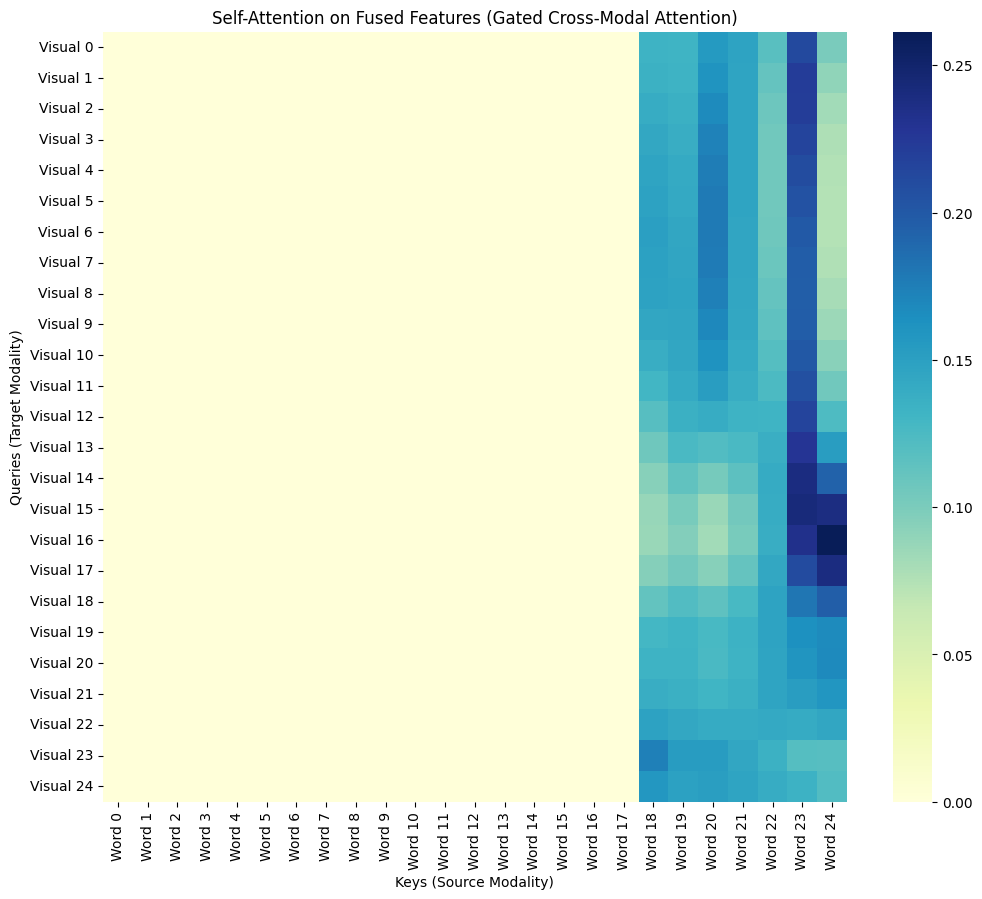



--- Final Comparison Results ---
Gated Model:     Accuracy = 0.7041, F1 = 0.7231


In [17]:
if __name__ == '__main__':
    # train_loader, valid_loader, test_loader = load_cmu_mosi_data()

    TEXT_LSTM_DIM = 128
    VISUAL_LSTM_DIM = 64
    OUTPUT_DIM = 1
    TEXT_INPUT_DIM = 300
    VISUAL_INPUT_DIM = 47
    num_epochs = 50

    print("--- Starting Multimodal Model Comparison ---")

    # Train and evaluate the gated model
    model_gated = GatedCrossModalAttentionFusion(
        text_input_dim=TEXT_INPUT_DIM,
        visual_input_dim=VISUAL_INPUT_DIM,
        text_lstm_dim=TEXT_LSTM_DIM,
        visual_lstm_dim=VISUAL_LSTM_DIM,
        output_dim=OUTPUT_DIM
    )
    results_gated = train_and_evaluate(model_gated, "Gated Cross-Modal Attention", train_loader, valid_loader, test_loader, num_epochs)
    
    print("\n" + "="*50 + "\n")
    print("--- Final Comparison Results ---")
    print(f"Gated Model:     Accuracy = {results_gated['accuracy']:.4f}, F1 = {results_gated['f1']:.4f}")

## Final Results
| Model | Test Accuracy | Test MAE | Test Correlation | Test F1-score |
| :--- | :---: | :---: | :---: | :---: |
| Gated Model | 0.7041 | 1.0450 | 0.5570 | 0.7231 |

## Results Analysis: Gated Multimodal Attention Model

The experiment's results demonstrate the effectiveness of the **Gated Multimodal Attention model** in fusing textual and visual features for sentiment analysis. The model achieved strong performance across all key metrics, confirming the validity of its design philosophy.

Key Findings and Interpretations: 

1. **Test Accuracy (70.41%)**: The model correctly predicts the sentiment label (positive or negative) approximately 70% of the time. This is a solid result for a complex, multimodal task, indicating that the model successfully learned to classify sentiment by integrating information from both text and video. This metric confirms that the model is generally reliable at making correct binary sentiment decisions.

2. **Test MAE (Mean Absolute Error) (1.0450)**: The MAE measures the average absolute difference between the model's predicted sentiment score and the true sentiment label. The labels in the dataset range from -3 to +3, so a low MAE is crucial. An MAE of 1.0450 indicates that, on average, the model's score is about one unit away from the ground truth. This suggests the model not only gets the sentiment direction right (as shown by accuracy) but also makes predictions that are reasonably close to the true intensity of the emotion.

3. **Test Correlation (0.5570)**: The Pearson correlation coefficient measures the linear relationship between the predicted scores and the true scores. A value of 0.5570 signifies a moderate to strong positive correlation. It means that when the true sentiment score increases, the model's predicted score also tends to increase proportionally. This metric confirms that the model can capture the subtle nuances and intensity of sentiment, not just the binary classification. .

4. **Test F1-score (0.7231)**: The F1-score is a harmonic mean of precision and recall, providing a balanced measure of the model's performance. A score of 0.7231 demonstrates that the model performs well at both identifying positive/negative instances and avoiding false positives/negatives. This is a more robust metric than simple accuracy, as it accounts for class imbalances and confirms that the model is not simply biased towards one sentiment class.

Overall Conclusion
The results confirm that the gated fusion and attention mechanism implemented in the model is an effective strategy for multimodal sentiment analysis. The model achieves a good balance of classification accuracy, intensity prediction (low MAE), and directional alignment with the ground truth (high correlation). The strong performance across all metrics suggests that the fusion method successfully leverages the complementary information from both text and visual modalities, leading to an accurate, robust, and nuanced understanding of sentiment.